In [28]:
%matplotlib inline

# ignore warnings!
import warnings
warnings.filterwarnings("ignore")

# data processing
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# graphing
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = """
\\usepackage{fourier}
\\usepackage{sourcesanspro}
"""
plt.style.use('fivethirtyeight')

# natural language processing
import nltk
nltk.data.path.append('/usr/share/nltk_data/')
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string

# machine learning imports
from funcsigs import signature
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
# import data
DF = pd.read_csv(
    "../data/combined_sentiments.csv", header=0, sep=",", on_bad_lines="skip"
)


def get_wordnet_pos(pos_tag):
    """lemmatises words by classifying them into their
    respective parts of speech"""
    if pos_tag.startswith("J"):
        return wordnet.ADJ
    elif pos_tag.startswith("V"):
        return wordnet.VERB
    elif pos_tag.startswith("N"):
        return wordnet.NOUN
    elif pos_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def check_digits(text):
    return any(i.isdigit() for i in text)


def clean_review(review):
    review = str(review).lower()
    review = [
        word.strip(string.punctuation) for word in review.split(" ")
    ]  # remove punctuation
    review = [word for word in review if not check_digits(word)]  # remove digits

    # remove stop words
    stop = stopwords.words("english")
    review = [token for token in review if token not in stop]
    # remove empty tokens
    review = [token for token in review if len(token) > 0]

    # tag each token with its part of speech (pos)
    pos_tags = pos_tag(review)
    review = [
        WordNetLemmatizer().lemmatize(tag[0], get_wordnet_pos(tag[1]))
        for tag in pos_tags
    ]

    # remove words with only one letter
    review = [token for token in review if len(token) > 1]
    review = " ".join(review)
    return review


# generate a cleaned, tokenised and lemmatised version of the reviews
DF["reviews.clean"] = DF["reviews.text"].apply(lambda x: clean_review(x))

reviews = DF["reviews.clean"].values.tolist()

"""
* create a list with all the unique words in the whole corpus of reviews.
* construct a feature vector that contains the counts of how often each word
occurs in the review.
"""
count_vectoriser = CountVectorizer()
wordbag = count_vectoriser.fit_transform(reviews)

In [30]:
"""
raw term frequency: frequency of each token
[term frequency-inverse document frequency]
* tf - idf(t, d) = tf(t, d) idf(t, d)
> tf(t, d) is the raw term frequency;
> idf(t, d) is the inverse document frequency: log (n_d / [1 + df(d, t)])
	* n - total number of documents
  * df(t, d) - number of documents where term t appears.
"""

from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True,
                         norm='l2',
                         smooth_idf=True)

np.set_printoptions(precision=2)

# feed the tf-idf transformer with our previously created bag
# tfidf.fit_transform(wordbag).toarray()

In [31]:
# split into train, test and validation sets
X = reviews
y = DF["sent.polarity"]
X_t, X_test, y_t, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_t, y_t, test_size=0.25, random_state=1, stratify=y_t
)

# create a parameter grid for the model to pick the best params
paramgrid = [
    {
        "vect__ngram_range": [(1, 1)],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [1.0, 10.0, 100.0],
    },
    {
        "vect__ngram_range": [(1, 1)],
        "vect__use_idf": [False],
        "vect__norm": [None],
        "clf__penalty": ["l1", "l2"],
        "clf__C": [1.0, 10.0, 100.0],
    },
]

# train the model!
tfidf = TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)
leftright = Pipeline([("vect", tfidf), ("clf", LogisticRegression(random_state=0))])

gridsearch = GridSearchCV(
    leftright, paramgrid, scoring="accuracy", cv=12, verbose=1, n_jobs=-1
)
gridsearch.fit(X_train, y_train)

Fitting 12 folds for each of 12 candidates, totalling 144 fits


# Evaluating Accuracy

Next, we can calculate the best and in-test accuracies. We can also plot
graphs --- here, the precision-recall and receiver operating characteristic
graph --- to evaluate the model's precision.

In [ ]:
print(f"best accuracy: {gridsearch.best_score_:.3f}")

clf = gridsearch.best_estimator_
print(f"accuracy in test: {clf.score(X_test, y_test):.3f}")

best accuracy: 0.770
accuracy in test: 0.781


## Making Predictions

We can ask the model to create a list of predictions for us from
values in the dataset. We can then calculate metrics such as the
false positive and true positive rate, which will aid us in plotting
the receiver operating characteristic graph later.

In [ ]:
PREDS = clf.predict(X_val)
ACTUALS = y_val.to_numpy()
ACTUALS[ACTUALS == 0] = -1

## Receiver operating characteristic

The precision-recall curve plots the rate of true positive predictions made
against the rate of false positive predictions. The dotted line shows
a scenario where the two are equal, and the plotted curve shows how well
the model fares against it. The higher the curve lies over the dotted line,
the higher the model's accuracy.

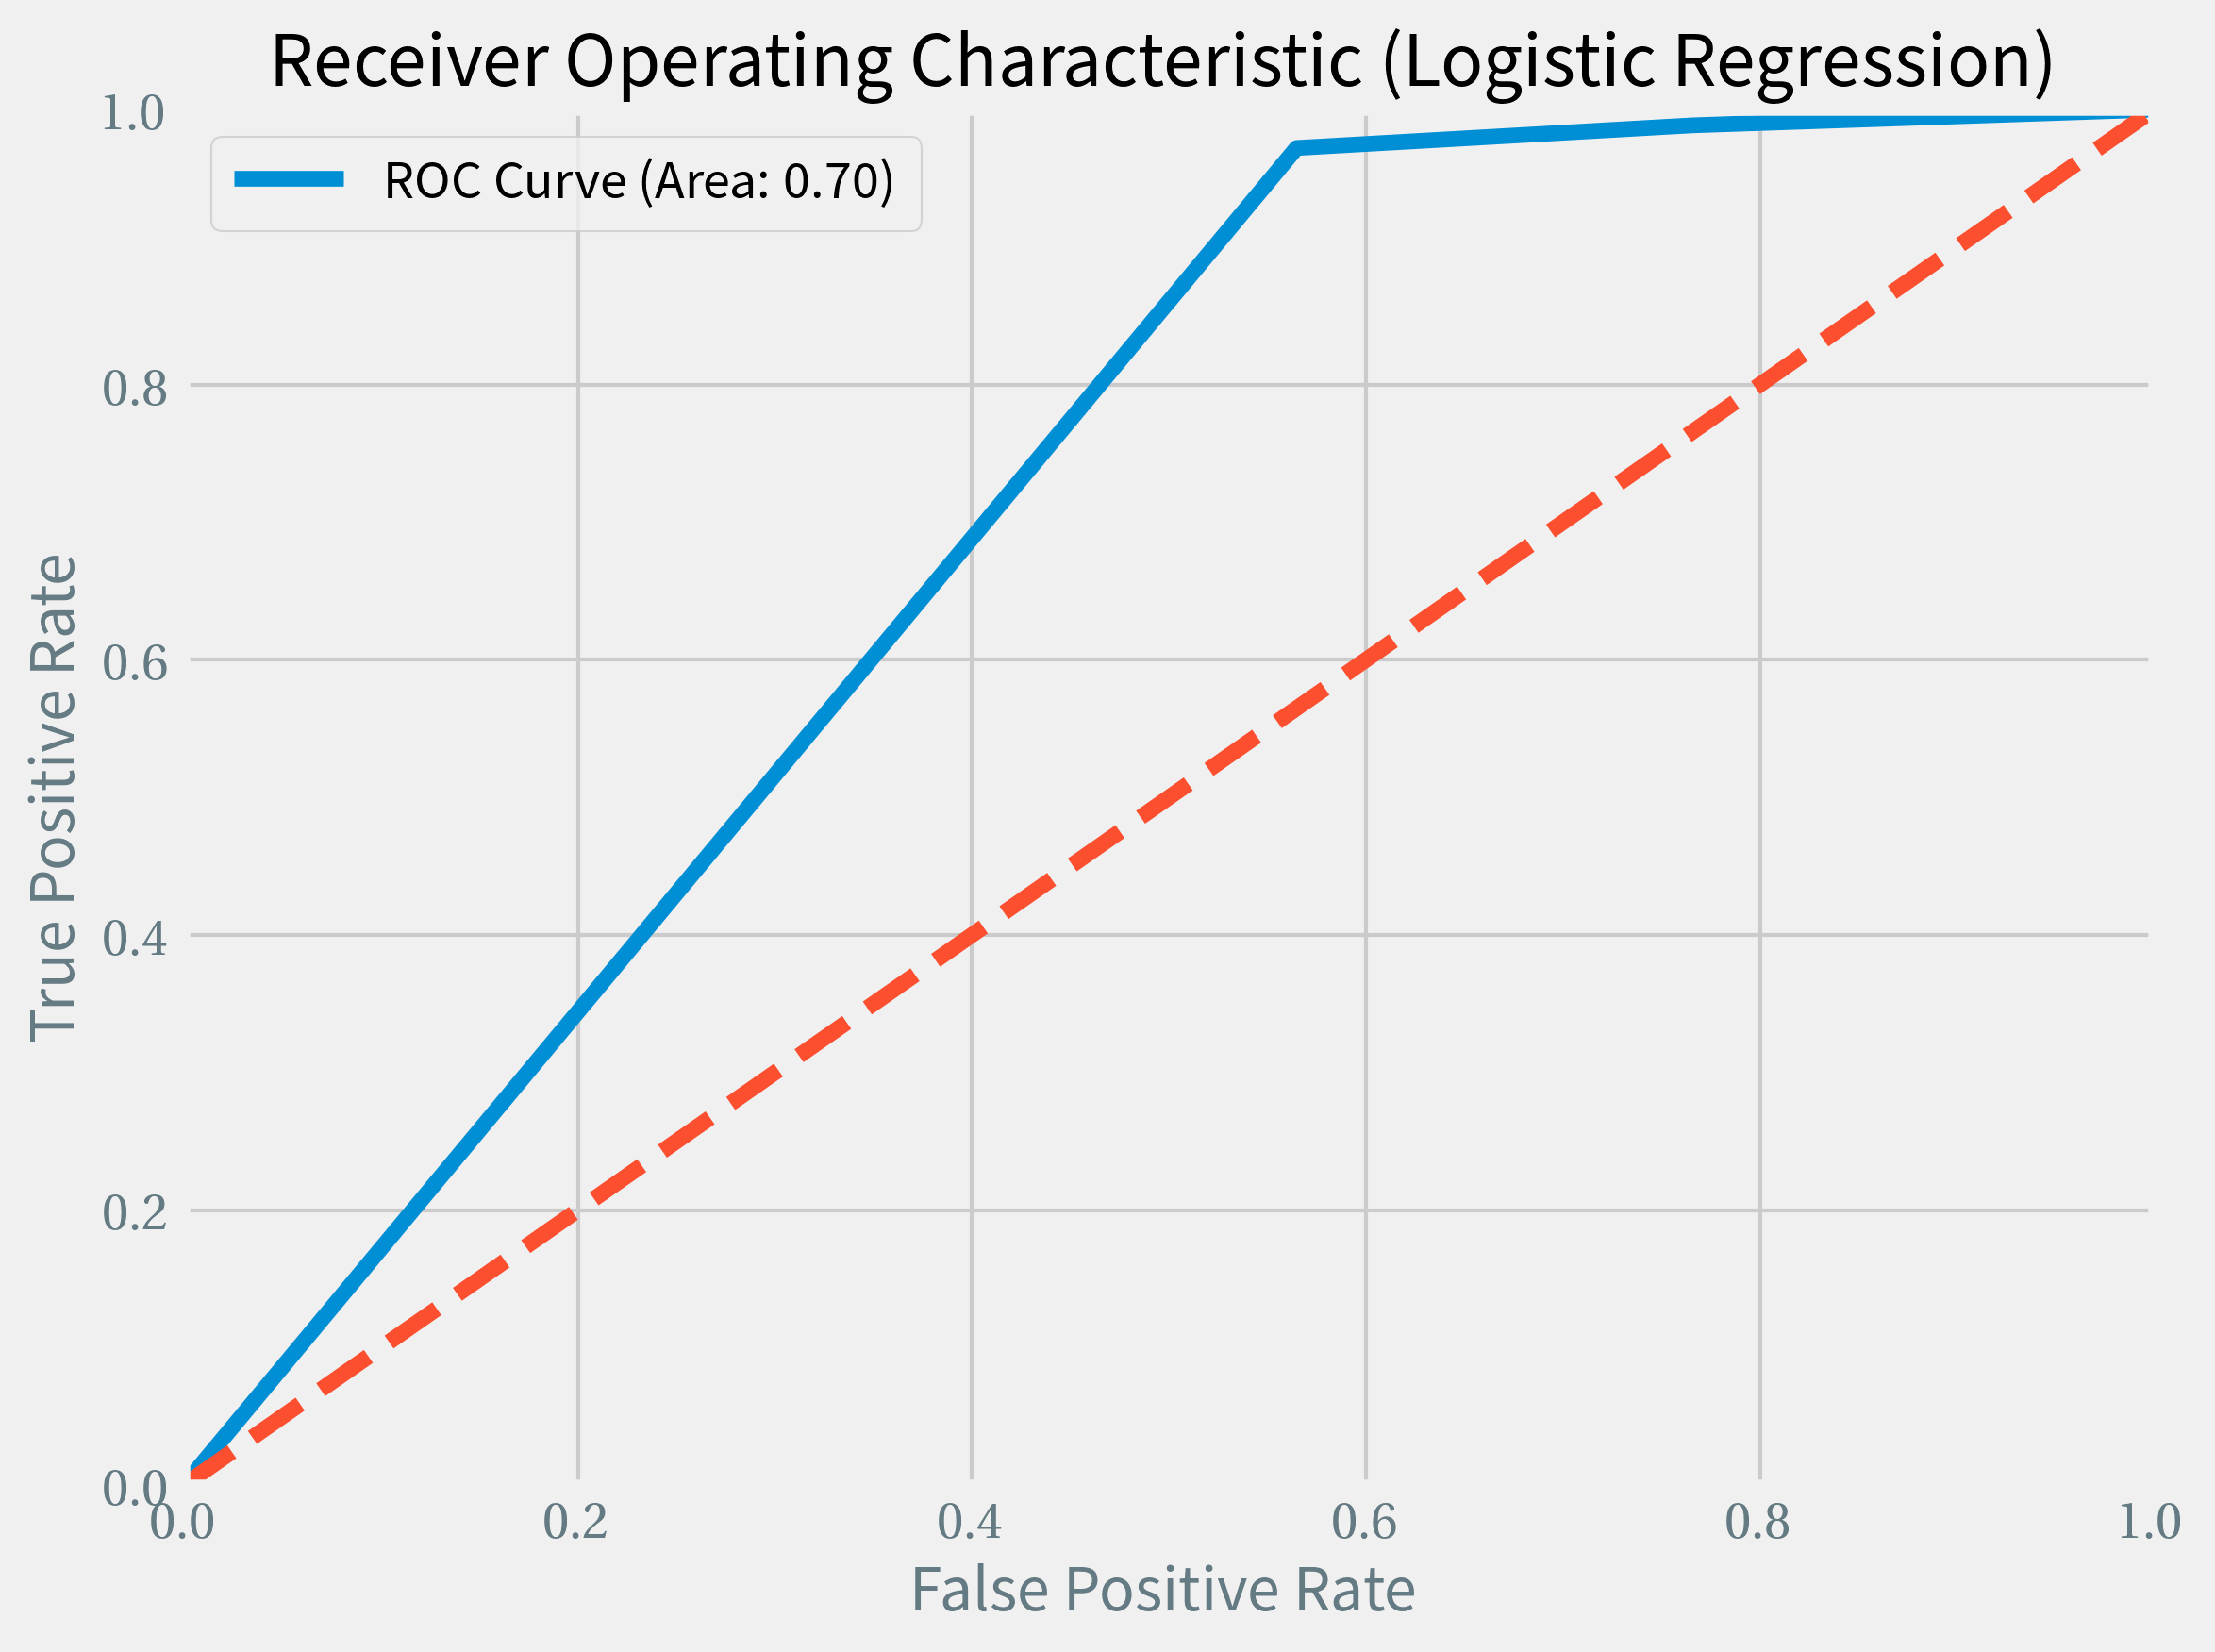

In [ ]:
false_rate, true_rate, thresholds = roc_curve(ACTUALS, PREDS, pos_label=1)
roc_auc = auc(false_rate, true_rate)

plt.plot(
    false_rate,
    true_rate,
    label=f"ROC Curve (Area: {roc_auc:.2f})",
)
plt.plot([0, 1], [0, 1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title("Receiver Operating Characteristic (Logistic Regression)")
plt.legend(loc="best")

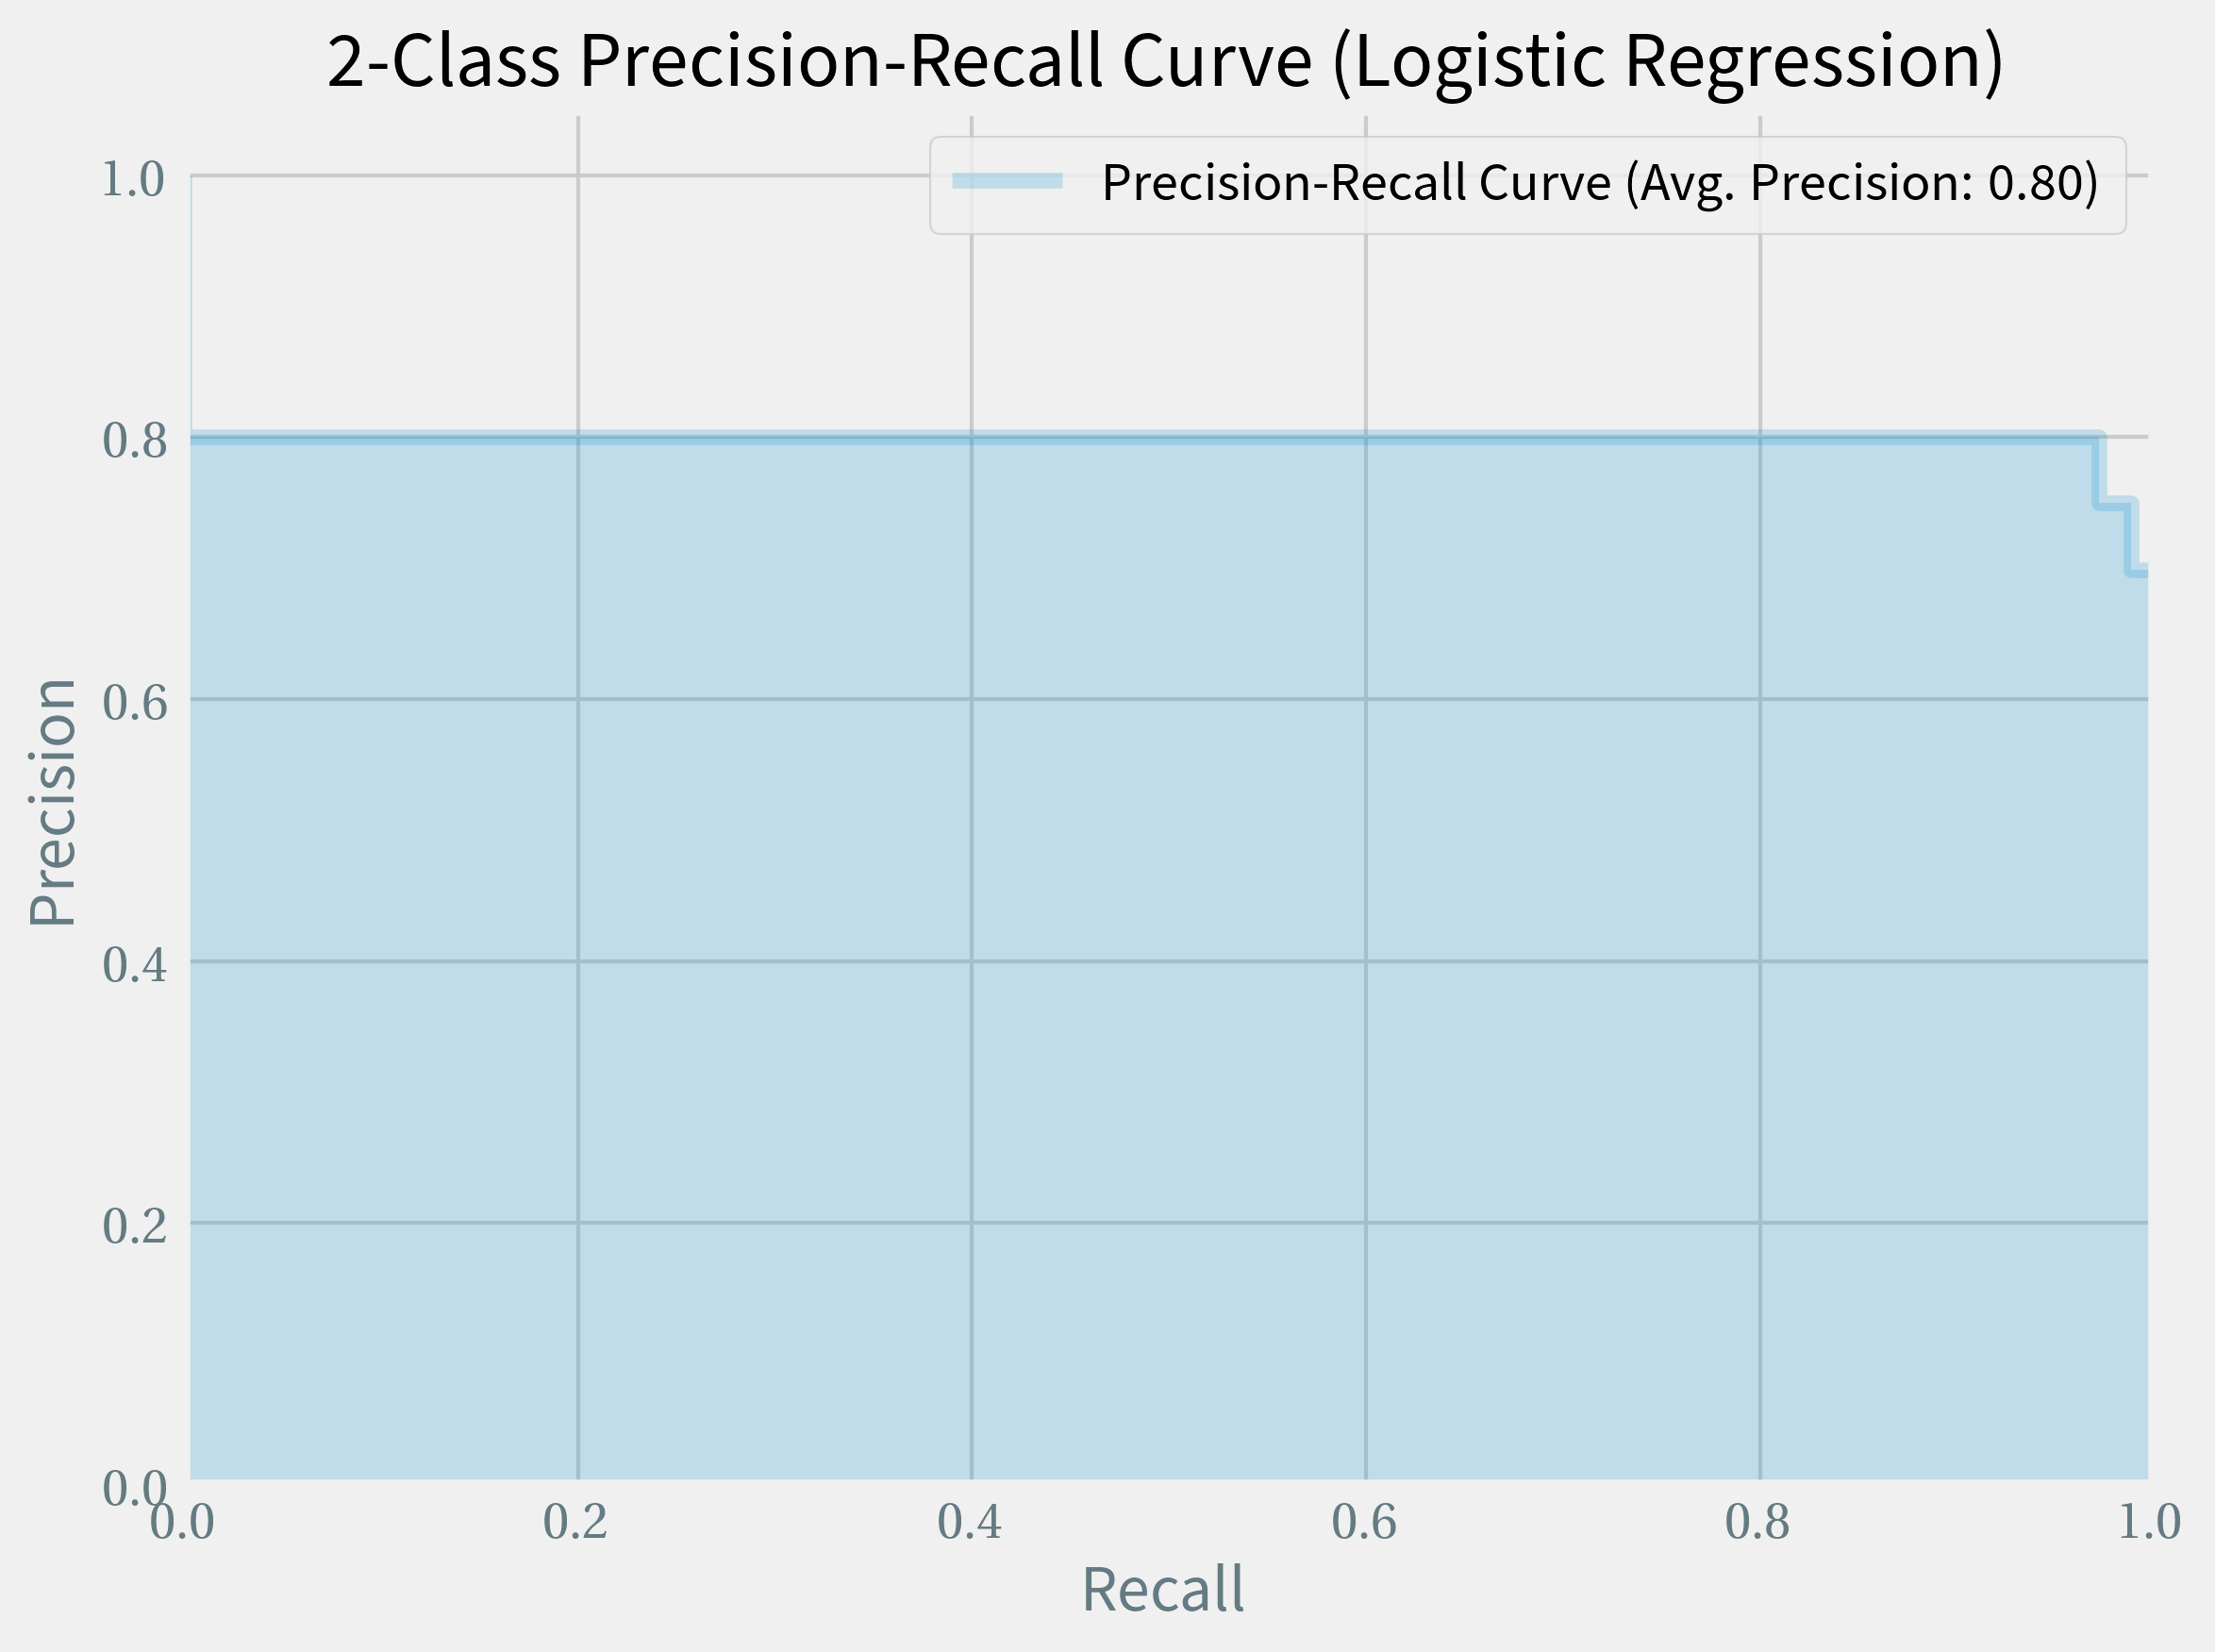

In [ ]:
AVG_PRECISION = average_precision_score(ACTUALS, PREDS, pos_label=1)
PRECISION, RECALL, _ = precision_recall_curve(ACTUALS, PREDS)
step_kwargs = (
    {"step": "post"} if "step" in signature(plt.fill_between).parameters else {}
)

# plt.figure(1)
plt.step(
    RECALL,
    PRECISION,
    alpha=0.2,
    where="post",
    label=f"Precision-Recall Curve (Avg. Precision: {AVG_PRECISION:.2f})",
)
plt.fill_between(RECALL, PRECISION, alpha=0.2, **step_kwargs)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title(f"2-Class Precision-Recall Curve (Logistic Regression)")
plt.legend(loc="best")